In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
from cmcrameri import cm
from datetime import datetime
import babet as bb

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
# experiments = ['pi', 'curr', 'incr']
experiments = ['curr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [3]:
exp['curr']

,Array,Chunk
Bytes,30.46 GiB,233.61 MiB
Shape,"(89, 3, 50, 13, 163, 289)","(2, 1, 50, 13, 163, 289)"
Count,1147 Tasks,135 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,30.46 GiB,233.61 MiB
Shape,"(89, 3, 50, 13, 163, 289)","(2, 1, 50, 13, 163, 289)"
Count,1147 Tasks,135 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
ivt = bb.Met.calc_ivt(exp['curr'].q, exp['curr'].u, exp['curr'].v).mean('number')

In [30]:
# Plot settings

region = 'eu'
if region=='uk':
    # UK
    lat_max = 62
    lat_min = 47
    lon_min = -12
    lon_max = 5
if region=='eu':
    #Europe
    lat_max = 70
    lat_min = 33
    lon_min = -27
    lon_max = 25

tp_min = 300 # IVT in kg/m^2/s
tp_max = 1000

p_min = 970 # Pressure in hPa
p_max= 1030

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


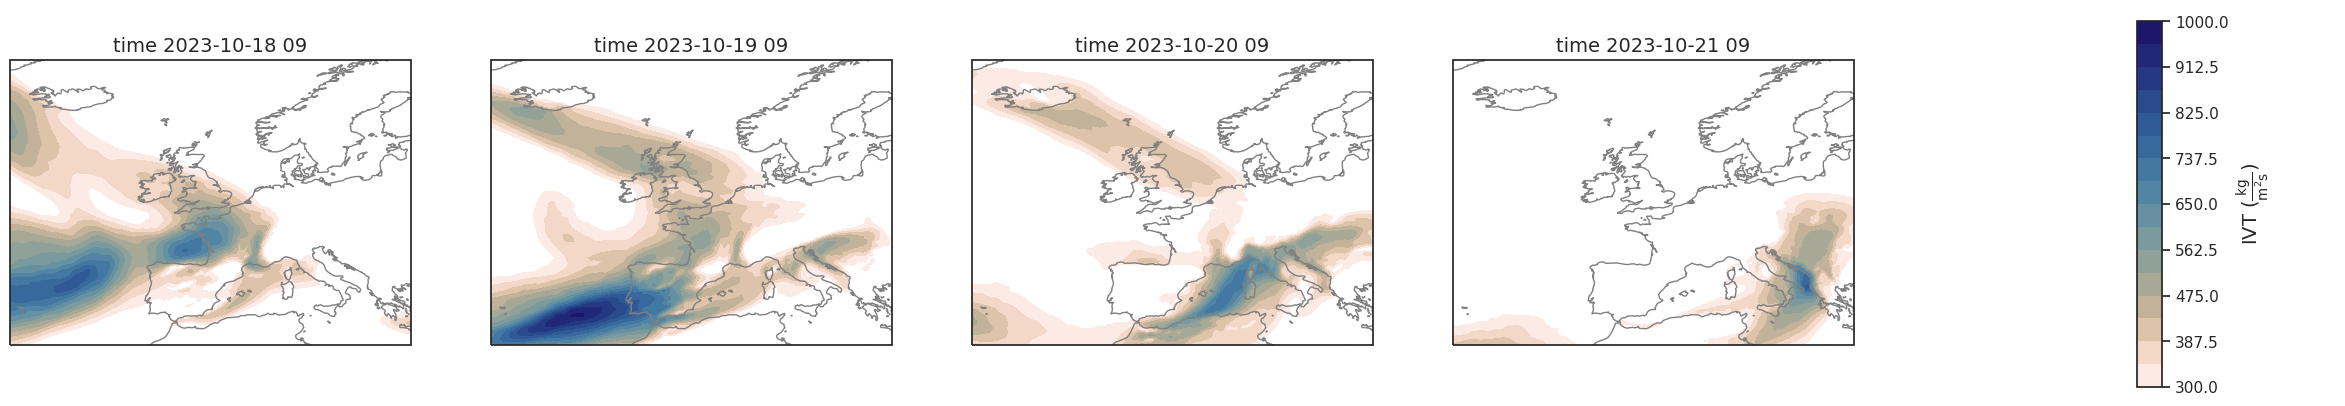

In [31]:
# Calculate integrated water vapour transport (IVT)

# figure and map setup
fs=14
inidate = '2023-10-15'
projection = ccrs.PlateCarree()
longitude =exp['curr'].longitude.values
latitude = exp['curr'].latitude.values
fig = plt.figure(1, figsize=(30, 5))

# Map -----------------
for t, time in enumerate(['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']):
    ax = plt.subplot(1,5,1+t, projection = projection)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # data for plotting
    tp_vals = ivt.sel(inidate=inidate, time=time).squeeze().values*100
    p_vals = exp['curr'].z.sel(inidate=inidate, time=time, level=850).mean('number').squeeze().values

    # tp as shading
    clevs_tp = np.linspace(tp_min, tp_max, 17)
    cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                    transform=projection)
    plt.title('time '+time[:13], fontsize=fs)

    # isobars as contours
    # clevs_p = np.linspace(p_min, p_max, 17)
    # cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
    #                 transform=projection)
    # plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(1,8,8)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}^2\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar.set_label(label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}^2\mathrm{s}}$)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

plt.savefig('figures/05_ivt_curr_{}.png'.format(region))
plt.savefig('figures/05_ivt_curr_{}.pdf'.format(region))

# Test whether Olivia's function yields the same result

In [4]:
# Olivia's function
def get_IVT(ds):
    
    ds =ds.copy()
    
    out = xr.Dataset(coords=ds.coords).drop('level')
    
    out['q_u'] = (ds.q.sel(level=slice(250,1000)) * ds.u.sel(level=slice(250,1000))).integrate('level') / 9.80665
    out['q_v'] = (ds.q.sel(level=slice(250,1000)) * ds.v.sel(level=slice(250,1000))).integrate('level') / 9.80665
    
    return out

In [5]:
ENS_IVT = get_IVT(curr).load()
river=(((ENS_IVT.q_u**2+ENS_IVT.q_v**2)**(1/2)))

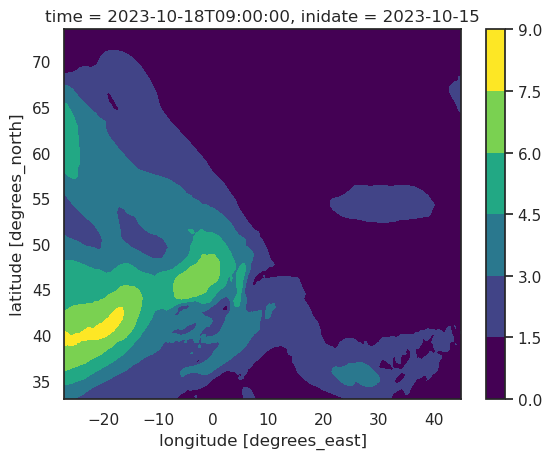

In [13]:
river.sel(time='2023-10-18 09', inidate='2023-10-15').mean('number').plot.contourf(vmax=10, vmin=1)

# Comparing experiments and inidates

# Lagranto to trace moisture sources

In [9]:
from datetime import datetime, timedelta
# from dypy.small_tools import interval
startdate = datetime(2023, 10, 15, 0)
enddate = startdate + timedelta(days=9)
# dates = [(d, d + timedelta(hours=48)) for d in
#           interval(startdate, enddate, timedelta(hours=6))]
dates = ['2023-10-15 00', '2023-10-15 06', '2023-10-15 09', '2023-10-15 12', '2023-10-15 15', '2023-10-15 18', '2023-10-15 21',
         '2023-10-16 00', '2023-10-16 06', '2023-10-16 09', '2023-10-16 12', '2023-10-16 15', '2023-10-16 18', '2023-10-16 21',
         '2023-10-17 00', '2023-10-17 06', '2023-10-17 09', '2023-10-17 12', '2023-10-17 15', '2023-10-17 18', '2023-10-17 21',
         '2023-10-18 00', '2023-10-18 06', '2023-10-18 09', '2023-10-18 12', '2023-10-18 15', '2023-10-18 18', '2023-10-18 21',
         '2023-10-19 00', '2023-10-19 06', '2023-10-19 09', '2023-10-19 12', '2023-10-19 15', '2023-10-19 18', '2023-10-19 21',
         '2023-10-20 00', '2023-10-20 06', '2023-10-20 09', '2023-10-20 12', '2023-10-20 15', '2023-10-20 18', '2023-10-20 21',
         '2023-10-21 00', '2023-10-21 06', '2023-10-21 09', '2023-10-21 12', '2023-10-21 15', '2023-10-21 18', '2023-10-21 21',
         '2023-10-22 00', '2023-10-22 06', '2023-10-22 09', '2023-10-22 12', '2023-10-22 15', '2023-10-22 18', '2023-10-22 21']

In [17]:
from lagranto import LagrantoRun
lrun = LagrantoRun(dates, workingdir=base_dir.format('curr'),
                   outputdir='output', version='ecmwf')

In [19]:
# create starting file to track air parcels every 20km
specifier = "'box.eqd(5,20,40,50,20)@profile(850,500,10)@hPa'"
out_create_startf = lrun.create_startf(startdate, specifier, tolist=True)

LagrantoException:  . /etc/profile.d/modules.sh
        module purge
        module load dyn_tools
        export NETCDF_FORMAT=CF
        
    cd '/tmp/user/27529/tmp59obelpp'
     startf.ecmwf 20231015_00 startf.4 'box.eqd(5,20,40,50,20)@profile(850,500,10)@hPa'
    ERROR: Unable to locate a modulefile for 'dyn_tools'
bash: line 7: startf.ecmwf: command not found


In [21]:
# test set up with a single date
out_caltra = lrun.caltra(*dates[1])

TypeError: caltra() missing 1 required positional argument: 'enddate'

In [ ]:
out_trace = lrun.trace(dates[1][0], field='Q 1.')